In [13]:
from pyspark.ml.regression import LinearRegression
import math

df=spark.read.csv('preprocessingbike.csv',inferSchema=True,header=True)
#print((df.count(), len(df.columns)))                 
#df.printSchema()                                    
#df.describe().show(5,False)                         
from pyspark.sql.functions import corr
#df.select(corr('Temperaturee','RentedBikeCount')).show()       

from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler

vec_assmebler=VectorAssembler(inputCols=['Hour', 'Temperaturee', 'Humidity_pct', 'WindSpeed_m_per_s','Visibility_10m','DewPointTemperature','SolarRadiation','Rainfall_mm','Snowfall_cm','FunctioningDay','Month','Weekend','Friday','Monday','Saturday','Sunday','Thursday','Tuesday','Wednesday','Autumn','Spring','Summer','Winter','has_holiday'],outputCol='features') 
features_df=vec_assmebler.transform(df)             

#features_df.printSchema()

model_df=features_df.select('features','RentedBikeCount')


train_df,test_df=model_df.randomSplit([0.7,0.3]) 

#print((train_df.count(), len(train_df.columns)))
#print((test_df.count(), len(test_df.columns)))

lin_Reg=LinearRegression(labelCol='RentedBikeCount')                

lr_model=lin_Reg.fit(train_df)                             

print('{}{}'.format('intercept:',lr_model.intercept))      
print('{}{}'.format('coefficients:',lr_model.coefficients)) 

training_predictions=lr_model.evaluate(train_df)        
print('{}{}'.format('train RMSE:',math.sqrt(training_predictions.meanSquaredError)))    
print('{}{}'.format('train Rsquare：',training_predictions.r2 )) 

test_results=lr_model.evaluate(test_df)
print('{}{}'.format('test RMSE:',math.sqrt(test_results.meanSquaredError)))
print('{}{}'.format('test Rsquare:',test_results.r2))


intercept:-131.68946008407667
coefficients:[27.400917853223117,16.471033798782766,-11.155865992568684,15.525425143995612,0.009418047103916694,11.107059999765841,-84.77338672869206,-55.91479230552327,28.254568163758744,937.318168169299,5.66001305777961,-34.30893260970765,36.096590185389815,-20.93169686237904,11.134887160120693,-66.91198358995206,-3.151363945405387,0.2861967726280461,43.03086742413573,134.6297241442234,45.33037048866864,9.058552121533218,-188.3979382084145,-102.26736484135213]
train MSE:428.1640153631305
train Rsquare：0.5591535278412652
test MSE:435.3848093575089
test Rsquare:0.5443864228383917


In [20]:
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import matplotlib.pyplot as plt

#glr=GeneralizedLinearRegression(labelCol="RentedBikeCount",family="poisson",maxIter=10,regParam=0.3)
# test RMSE:  454.9127390108104 test Rsquare:  0.5025993940698775
glr=GeneralizedLinearRegression(labelCol="RentedBikeCount",family="gaussian",maxIter=10,regParam=0.3)
# test RMSE:  435.3782528035389 test Rsquare:  0.544400145101783

model = glr.fit(train_df)
 
print("Coefficients: ", model.coefficients)
print("Intercept: ", model.intercept)
print(model.summary)

tdata = model.transform(test_df)

rmse = RegressionEvaluator(labelCol="RentedBikeCount", predictionCol="prediction", metricName="rmse")
rmse = rmse.evaluate(tdata)
r2 = RegressionEvaluator(labelCol="RentedBikeCount", predictionCol="prediction", metricName="r2")
r2 = r2.evaluate(tdata)

print("test RMSE: ", rmse)
print("test Rsquare: ", r2)


Coefficients:  [27.398733780975046,16.67990765004143,-11.073153093863143,15.503984946571537,0.00969003533185501,10.843810655129808,-84.55142710327357,-55.947156219095326,28.056377040910437,936.7208924227533,5.662921673413936,-34.30987886761286,36.075744669413126,-20.860208852583135,11.112127013485267,-66.89162837342343,-3.1878009519688373,0.3098079790886343,42.9958371335114,134.52820205081304,45.27391030547212,9.448654151542698,-188.6299950387974,-102.17995827823141]
Intercept:  -138.01065024785584
Coefficients:
            Feature  Estimate Std Error  T Value P Value
        (Intercept) -138.0107  433.0106  -0.3187  0.7499
               Hour   27.3987    0.8754  31.2974  0.0000
       Temperaturee   16.6799    4.2271   3.9460  0.0001
       Humidity_pct  -11.0732    1.2005  -9.2237  0.0000
  WindSpeed_m_per_s   15.5040    6.0913   2.5453  0.0109
     Visibility_10m    0.0097    0.0117   0.8283  0.4075
DewPointTemperature   10.8438    4.4344   2.4454  0.0145
     SolarRadiation  -84.5

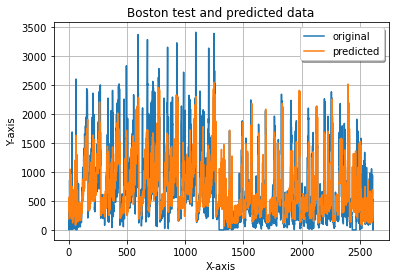

In [18]:
x_ax = range(0, tdata.count())
y_pred=tdata.select("prediction").collect()
y_orig=tdata.select("RentedBikeCount").collect()
 
plt.plot(x_ax, y_orig, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Boston Generalized Linear Regression")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 